### Connect to Drive

In [ ]:
# Import the Google Colab drive module to access Google Drive
from google.colab import drive

# Mount Google Drive to the '/gdrive' directory in the Colab environment
drive.mount('/gdrive')

# Change the current working directory to the Dataset folder in Google Drive
%cd /gdrive/My Drive/Dataset

Mounted at /gdrive
/gdrive/My Drive/ANN&DL Challenges


### Import libraries

In [ ]:
# Set a fixed random seed for reproducible results across all libraries
seed = 42

# Configure environment variables for better performance and reproducibility
import os
# Suppress TensorFlow informational and warning messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Set Python hash seed for consistent hashing behavior
os.environ['PYTHONHASHSEED'] = str(seed)
# Set matplotlib configuration directory to current working directory
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Suppress Python warnings to clean up output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import NumPy and set its random seed for reproducible random number generation
import numpy as np
np.random.seed(seed)

# Import logging module for potential use in debugging
import logging

# Import random module and set its seed for reproducible random operations
import random
random.seed(seed)

In [ ]:
# Import TensorFlow and its key modules for deep learning
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Configure TensorFlow logging and verbosity settings
tf.autograph.set_verbosity(0)  # Disable autograph verbose output
tf.get_logger().setLevel(logging.ERROR)  # Only show error messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Legacy logging setting

# Set TensorFlow random seeds for reproducible model training
tf.random.set_seed(seed)  # TensorFlow 2.x random seed
tf.compat.v1.set_random_seed(seed)  # TensorFlow 1.x compatibility random seed

# Print TensorFlow version for reference
print(tf.__version__)

2.15.0


In [ ]:
# Import pandas for data manipulation and analysis
import pandas as pd

# Import seaborn for statistical data visualization
import seaborn as sns

# Import datetime for date and time operations
from datetime import datetime

# Import matplotlib for plotting and set default font size
import matplotlib.pyplot as plt
plt.rc('font', size=16)  # Set default font size for all plots

# Import sklearn preprocessing and model selection utilities
from sklearn.preprocessing import MinMaxScaler  # For feature scaling
from sklearn.model_selection import train_test_split  # For splitting datasets

### Load and process data

In [ ]:
# Load the main time series dataset from numpy file
dataset = np.load('training_data.npy')

# Load category labels for each time series
label = np.load('categories.npy')

# Load valid period indices indicating which parts of each time series are valid
valid = np.load('valid_periods.npy')

In [ ]:
# Display the shape of the loaded dataset (number of time series, length of each series)
dataset.shape

(48000, 2776)

In [ ]:
# Initialize list to store extracted valid portions of time series
valid_dataset = []

# Extract valid portions from each time series based on valid period indices
for i,v in enumerate(valid):
    start = v[0]  # Start index of valid period
    end = v[1]    # End index of valid period
    # Extract the valid portion from the time series (inclusive of end index)
    valid_dataset.append(dataset[i][start:end+1])  # +1 to include the 'end' index

# Convert the list of valid time series back to a NumPy array for efficient processing
valid_dataset = np.array(valid_dataset)

# Display the shape of the valid dataset
valid_dataset.shape

(48000,)

### Inspecting dataset

In [ ]:
# Extract unique category labels from the dataset
unique_labels = np.unique(label)

# Calculate the length of each time series in the valid dataset
unique_lengths = []
for i,v in enumerate(valid_dataset):
  unique_lengths.append(len(v))

# Get unique lengths and their frequency counts
unique_vals, unique_counts = np.unique(unique_lengths,return_counts=True)

In [ ]:
# Display the distribution of time series lengths (length : count)
for i in range(len(unique_vals)):
    print(str(unique_vals[i])+' : '+str(unique_counts[i]))

24 : 2
25 : 3
27 : 2
28 : 1
30 : 3
31 : 2
33 : 1
35 : 1
36 : 2
37 : 1
41 : 1
42 : 37
43 : 123
44 : 80
45 : 49
46 : 41
47 : 44
48 : 520
49 : 1104
50 : 487
51 : 6703
52 : 659
53 : 49
54 : 28
55 : 69
56 : 272
57 : 287
58 : 71
59 : 127
60 : 312
61 : 340
62 : 83
63 : 53
64 : 965
65 : 188
66 : 19
67 : 39
68 : 30
69 : 21
70 : 14
71 : 47
72 : 69
73 : 345
74 : 7
75 : 12
76 : 11
77 : 23
78 : 9
79 : 8
80 : 32
81 : 16
82 : 7
83 : 11
84 : 625
85 : 45
86 : 759
87 : 8
88 : 11
89 : 22
90 : 10
91 : 28
92 : 56
93 : 10
94 : 77
95 : 33
96 : 44
97 : 173
98 : 61
99 : 3
100 : 15
101 : 9
102 : 36
103 : 12
104 : 8
105 : 13
106 : 29
107 : 47
108 : 132
109 : 114
110 : 36
111 : 10
112 : 11
113 : 36
114 : 52
115 : 83
116 : 73
117 : 23
118 : 26
119 : 157
120 : 101
121 : 165
122 : 9
123 : 16
124 : 35
125 : 12
126 : 13
127 : 17
128 : 13
129 : 12
130 : 62
131 : 60
132 : 353
133 : 312
134 : 21
135 : 14
136 : 51
137 : 15
138 : 16
139 : 17
140 : 155
141 : 113
142 : 23
143 : 70
144 : 282
145 : 156
146 : 32
147 : 9
148 : 3

In [ ]:
# Set length limit for filtering time series
limit = 100
count = 0

# Count how many time series have length less than the limit
for i in range(len(unique_vals)):
  if unique_vals[i] == limit:
    break
  count = count + unique_counts[i]

# Calculate the proportion of time series shorter than the limit
count / 48000

0.3207291666666667

### Delete shorter lengths (based on the limit)

In [ ]:
# Filter out time series that are shorter than the specified limit
reduced_valid_dataset = []
for v in valid_dataset:
  # Only keep time series with length >= limit
  if len(v) >= limit:
    reduced_valid_dataset.append(v)

# Convert back to numpy array and update the valid_dataset
valid_dataset = np.array(reduced_valid_dataset)

# Display the shape after filtering
valid_dataset.shape

(32605,)

### Build sequences

In [ ]:
# Define parameters for sequence building
window = 200                    # Length of input sequences (historical data window)
stride = 25                     # Step size between consecutive sequences
telescope = 9                   # Length of prediction horizon (future values to predict)
autoregressive_telescope = 3    # Number of steps for autoregressive prediction

In [38]:
def build_sequences(telescope=telescope, valid_dataset = valid_dataset, categories = label, window = window, stride=stride):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = [] # Slice seen
    unseen = [] # Unseen slices
    new_categories = [] # New categories

    for i,v in enumerate(valid_dataset):
      # Check if the dimension of the dataset can be divisible to window size
      padding_check = len(v) % window
      temp_dataset = np.array(v)

      # If not divisible, then fix the length of the df
      if(padding_check != 0):
          # Compute padding length
          padding_len = window - len(v) % window

          # Compute the mean of the series
          avg = np.mean(v)

          # Fill the padding with the mean
          padding = np.empty(padding_len, dtype='float32')
          padding.fill(avg)
          #padding = np.zeros(padding_len, dtype='float32')
          temp_dataset = np.concatenate((padding,v))

          assert len(temp_dataset) % window == 0

      for idx in np.arange(0,len(v)-window-telescope,stride):
          dataset.append(temp_dataset[idx:idx+window])
          unseen.append(temp_dataset[idx+window:idx+window+telescope])
          new_categories.append(categories[i])

    dataset = np.array(dataset)
    unseen = np.array(unseen)
    new_categories = np.array(new_categories)
    return dataset, unseen, new_categories

In [ ]:
# Build input sequences (X), target sequences (y), and categories (cat)
X, y, cat = build_sequences(telescope)

# Display the shapes of the created arrays
X.shape, y.shape, cat.shape

((106452, 200), (106452, 9), (106452,))

### Build Train, Validation and Test set
Distribute equally the time series of different classes among the 3 sets.

In [ ]:
# Convert numpy arrays to pandas DataFrames for easier manipulation
# Each row represents one time series sequence
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [ ]:
# Add category labels to both input and target DataFrames for stratified splitting
X['category'] = cat
y['category'] = cat

In [ ]:
# Split data into training+validation and test sets
# Using stratify to maintain class distribution across splits
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size = 0.1,           # 10% for testing
    stratify = X['category'],  # Maintain category proportions
    random_state = seed        # For reproducible splits
)

In [ ]:
# Verify the shapes after the first split
X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape

((95806, 201), (10646, 201), (95806, 10), (10646, 10))

In [ ]:
# Further split training+validation into separate training and validation sets
# Validation set size equals test set size for balanced evaluation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test),              # Same size as test set
    stratify = X_train_val['category'],   # Maintain category proportions
    random_state = seed,                  # For reproducible splits
)

# Display shapes of all splits
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((85160, 201), (10646, 201), (85160, 10), (10646, 10))

In [ ]:
# Remove the 'category' column from all datasets as it's no longer needed
# Keep only the time series data for model training
X_train = X_train.drop('category', axis=1)
X_val = X_val.drop('category', axis=1)
X_test = X_test.drop('category', axis=1)

y_train = y_train.drop('category', axis=1)
y_val = y_val.drop('category', axis=1)
y_test = y_test.drop('category', axis=1)

In [ ]:
# Verify final shapes of all datasets after preprocessing
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((85160, 200), (85160, 9), (10646, 200), (10646, 9), (10646, 200), (10646, 9))

In [ ]:
# Adjust target sequences for autoregressive prediction
# Reduce prediction horizon to match autoregressive telescope size
to_cut = telescope - autoregressive_telescope  # Calculate how much to cut
y_train = pd.DataFrame(y_train)
y_train = y_train.iloc[:,:-to_cut]  # Remove last 'to_cut' columns
y_train.shape

(85160, 3)

In [ ]:
# Apply the same target adjustment to validation set
y_val = pd.DataFrame(y_val)
y_val = y_val.iloc[:,:-to_cut]  # Remove last 'to_cut' columns
y_val.shape

(10646, 3)

In [ ]:
# Add an extra dimension to all datasets for neural network compatibility
# Convert from 2D (samples, features) to 3D (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [ ]:
# Final verification of all dataset shapes after dimension expansion
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((85160, 200, 1),
 (85160, 3, 1),
 (10646, 200, 1),
 (10646, 3, 1),
 (10646, 200, 1),
 (10646, 9, 1))

### Train the model

In [ ]:
# Define model architecture and training parameters
input_shape = X_train.shape[1:]   # Shape of input sequences (timesteps, features)
output_shape = y_train.shape[1:]  # Shape of output sequences (timesteps, features)
batch_size = 64                   # Number of samples per training batch
epochs = 200                      # Maximum number of training epochs

In [52]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True, name='gru'), name='bidirectional_gru')(input_layer)
    x = tfkl.Conv1D(128, 3, padding='same', activation='gelu', name='conv2')(x)

    x = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True, name='gru'), name='bidirectional_gru1')(x)
    x = tfkl.Conv1D(128, 3, padding='same', activation='gelu', name='conv')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=True, name='gru'), name='bidirectional_gru2')(x)
    x = tfkl.Conv1D(128, 3, padding='same', activation='gelu', name='conv1')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_gru (Bidirec  (None, 200, 64)           6720      
 tional)                                                         
                                                                 
 conv2 (Conv1D)              (None, 200, 128)          24704     
                                                                 
 bidirectional_gru1 (Bidire  (None, 200, 64)           31104     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 128)          24704     
                                                                 
 bidirectional_gru2 (Bidire  (None, 200, 64)       

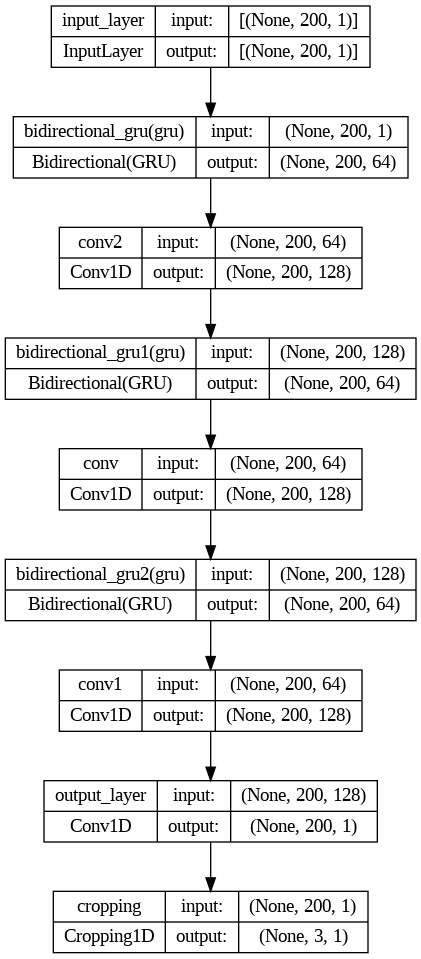

In [ ]:
# Build the Conv-GRU model with specified input and output shapes
model = build_CONV_LSTM_model(input_shape, output_shape)

# Display model architecture summary
model.summary()

# Visualize the model architecture with layer shapes
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model with training and validation data
history = model.fit(
    X_train,                    # Training input sequences
    y_train,                    # Training target sequences
    validation_data=(X_val,y_val),  # Validation data for monitoring
    epochs=epochs,              # Maximum number of epochs
    batch_size=batch_size,      # Batch size for training
    verbose=1,                  # Print training progress
    callbacks = [
        # Stop training early if validation loss stops improving
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, 
                                  restore_best_weights=True, min_delta = 0.0001),
        # Reduce learning rate when validation loss plateaus
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, 
                                      factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
1331/1331 [==============================] - 67s 50ms/step - loss: 0.0376 - val_loss: 0.0084 - lr: 0.0010
Epoch 2/200
1331/1331 [==============================] - 62s 47ms/step - loss: 0.0055 - val_loss: 0.0049 - lr: 0.0010
Epoch 3/200
1331/1331 [==============================] - 63s 48ms/step - loss: 0.0045 - val_loss: 0.0044 - lr: 0.0010
Epoch 4/200
1331/1331 [==============================] - 62s 47ms/step - loss: 0.0043 - val_loss: 0.0044 - lr: 0.0010
Epoch 5/200
1331/1331 [==============================] - 61s 46ms/step - loss: 0.0041 - val_loss: 0.0040 - lr: 0.0010
Epoch 6/200
1331/1331 [==============================] - 61s 46ms/step - loss: 0.0040 - val_loss: 0.0038 - lr: 0.0010
Epoch 7/200
1331/1331 [==============================] - 63s 47ms/step - loss: 0.0037 - val_loss: 0.0038 - lr: 0.0010
Epoch 8/200
1331/1331 [==============================] - 62s 46ms/step - loss: 0.0035 - val_loss: 0.0038 - lr: 0.0010
Epoch 9/200
1331/1331 [==============================] -

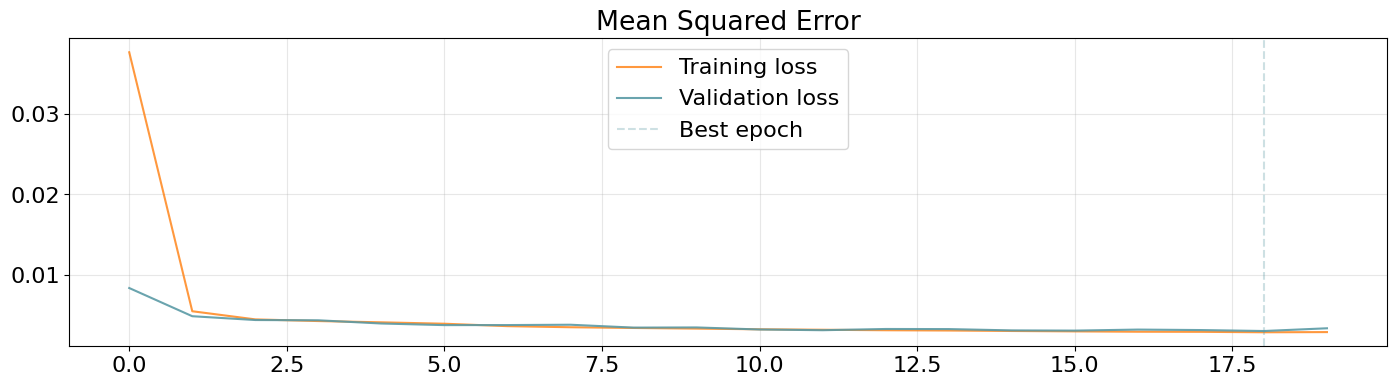

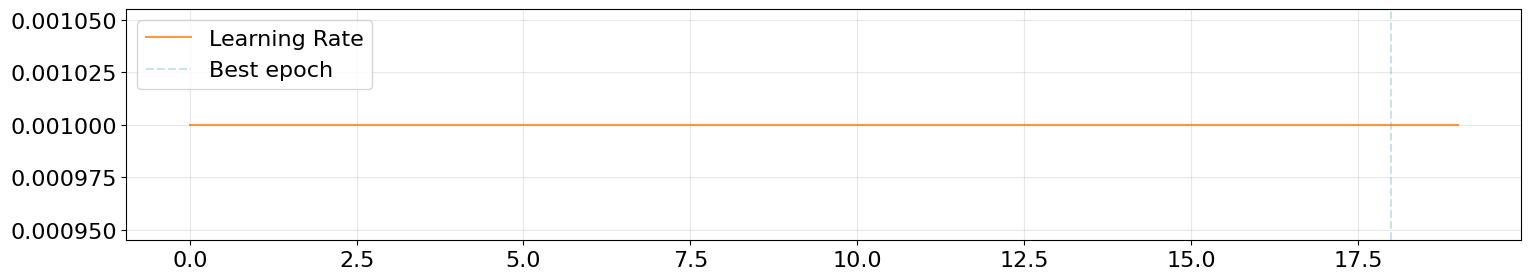

In [ ]:
# Find the epoch with the best (lowest) validation loss
best_epoch = np.argmin(history['val_loss'])

# Plot training and validation loss over epochs
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Plot learning rate schedule over epochs
plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Save the trained model with a descriptive filename
model.save('Conv_GRU32_Gelu_NoUnder100Seq_Stride25_Autoreg')

In [ ]:
# Load the previously saved trained model
model = tfk.models.load_model('Conv_GRU32_Gelu_NoUnder100Seq_Stride25_Autoreg')

### Autoregressive prediction

In [ ]:
# Perform autoregressive forecasting on test data
# Predict step by step, using previous predictions as input for next predictions
reg_predictions = np.array([])  # Store all predictions
X_temp = X_test                 # Working copy of test input

# Loop through prediction steps with autoregressive telescope size
for reg in range(0,telescope,autoregressive_telescope):
    # Make prediction for current step
    pred_temp = model.predict(X_temp,verbose=0)
    
    # Store predictions (first iteration or concatenate with previous)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    
    # Update input for next iteration: remove oldest values and add new predictions
    X_temp = np.concatenate((X_temp[:,autoregressive_telescope:,:],pred_temp), axis=1)

In [ ]:
# Display the shape of the autoregressive predictions
reg_predictions.shape

(10646, 9, 1)

In [ ]:
# Evaluate model performance on test data

# Print the shape of the predictions for verification
print(f"Predictions shape: {reg_predictions.shape}")

# Calculate and display Mean Squared Error (MSE)
# Flatten arrays to compute error across all predicted values
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and display Mean Absolute Error (MAE)
# MAE is less sensitive to outliers than MSE
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), reg_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (10646, 9, 1)
Mean Squared Error: 0.005259096156805754
Mean Absolute Error: 0.045672934502363205
